In [ ]:
#TODO: Add training and test errors

#ALY 6015#

##Advanced Regression - Logistic, Ridge, and Lasso##

##Author: Fidel Rodriguez##


#Part 1a - Import necessary packages#

* I tend to copy/paste these packages from previous pieces of work and then clean up the import list as appropriate.

In [ ]:
import numpy as np
import random
import pandas as pd
import os
import seaborn as sns
import statsmodels.api as sm
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from pylab import rcParams
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


rcParams['figure.figsize'] = (23, 8)
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

#Part 1a - Logistic Regression#
##Borrowed from: Learning Predictive Analytics with Python by Ashish Kumar##
###https://learning.oreilly.com/library/view/learning-predictive-analytics/9781783983261/ch06.html###

In [ ]:
df=pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTv5mP8SfzSH7kze3N7fR8uBMOhMEwVuVVaUE6fqnSfoWNv0e-LOHr9gT7jF1Oug54RzRVmCBNErLKq/pub?output=csv')
df.columns = {'Gender','Transaction'}
df.head()

,Gender,Transaction
0,Female,Yes
1,Female,Yes
2,Female,No
3,Male,No
4,Male,Yes


##Create a simple contingency table to support the following calculations:
* P(F)
* P(M)
* P(T)
* P (T)
* Probability (Transaction | Male)
* Probability (~Transaction | Male)
* Probability (Transaction | Female)
* Probability (~Transaction | Female)

In [ ]:
contingency_table=pd.crosstab(df['Gender'],df['Transaction'])
contingency_table

Transaction,No,Yes
Gender,,
Female,106,159
Male,125,121


* P(F) = (106+159)/(106+125+159+121)
* P(M) = (125+121) / (106+125+159+121)
* P(T) = (159+121) / (106+125+159+121)
* P(~T) = (106+125) / (106+125+159+121)
* Probability (Transaction | Male)
* Probability (~Transaction | Male)
* Probability (Transaction | Female)
* Probability (~Transaction | Female)
* Probability (Transaction | Male) = 121/246
* Probability (~Transaction | Male) = 125/246
* Probability (Transaction | Female) = 159/265
* Probability (~Transaction | Female) = 106/265

##Convert the contingency table to percentages

In [ ]:
contingency_table.astype('float').div(contingency_table.sum(axis=1),axis=0)*100.00

Transaction,No,Yes
Gender,,
Female,40.000000,60.000000
Male,50.813008,49.186992


In [ ]:
contingency_table2=pd.crosstab(df['Transaction'],df['Gender'])

In [ ]:
contingency_table2.astype('float').div(contingency_table2.sum(axis=1),axis=0)*100.00

Gender,Female,Male
Transaction,,
No,45.887446,54.112554
Yes,56.785714,43.214286


#Motivating Example - Predicting Funeral Plot Purchases

In [ ]:
funeral_df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSG-GQwdpZkTC-UV9cTMCjhSwkmc5VNb-IzH5yG6neHxk3dB_a-Ttlg-8Nynttq_NmnROAt-OZmx9Ax/pub?output=csv')
funeral_df.shape

(15, 2)

In [ ]:
funeral_df.head(3)

,Age,Transaction
0,22,0
1,25,0
2,47,1


##Plot the data

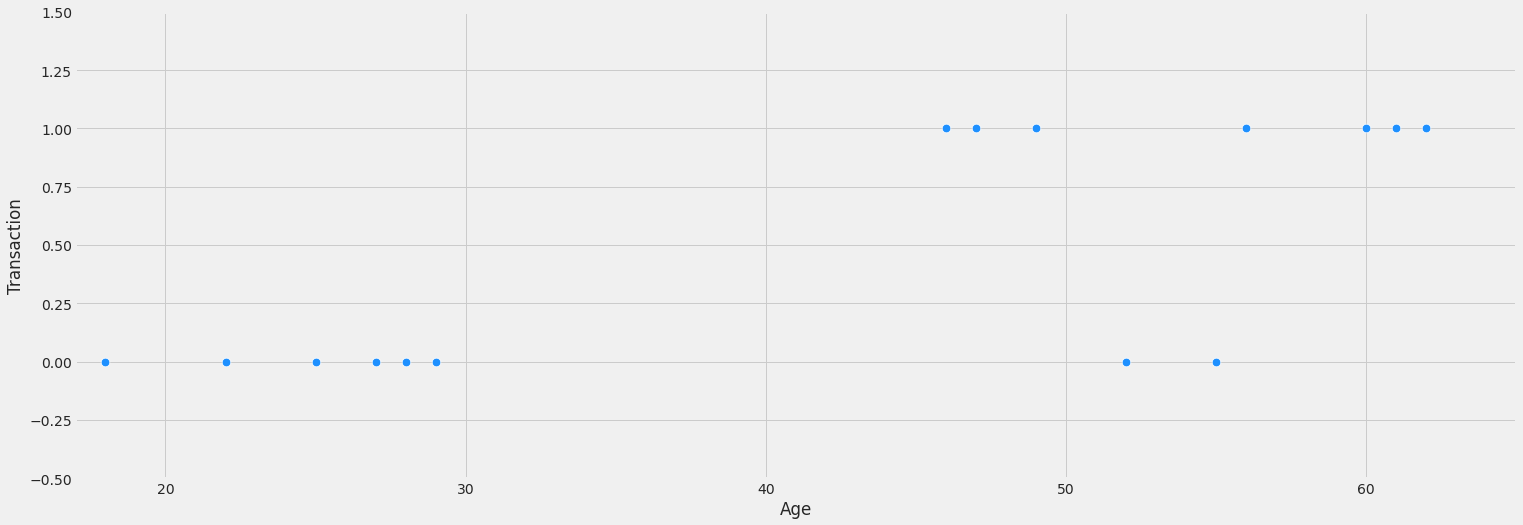

In [ ]:
ax = sns.scatterplot(x = 'Age', y = 'Transaction', data = funeral_df, s = 75, color = 'dodgerblue')
plt.xlim([17,65])
plt.ylim([-.5,1.5]);

##Attempt incorrect analysis

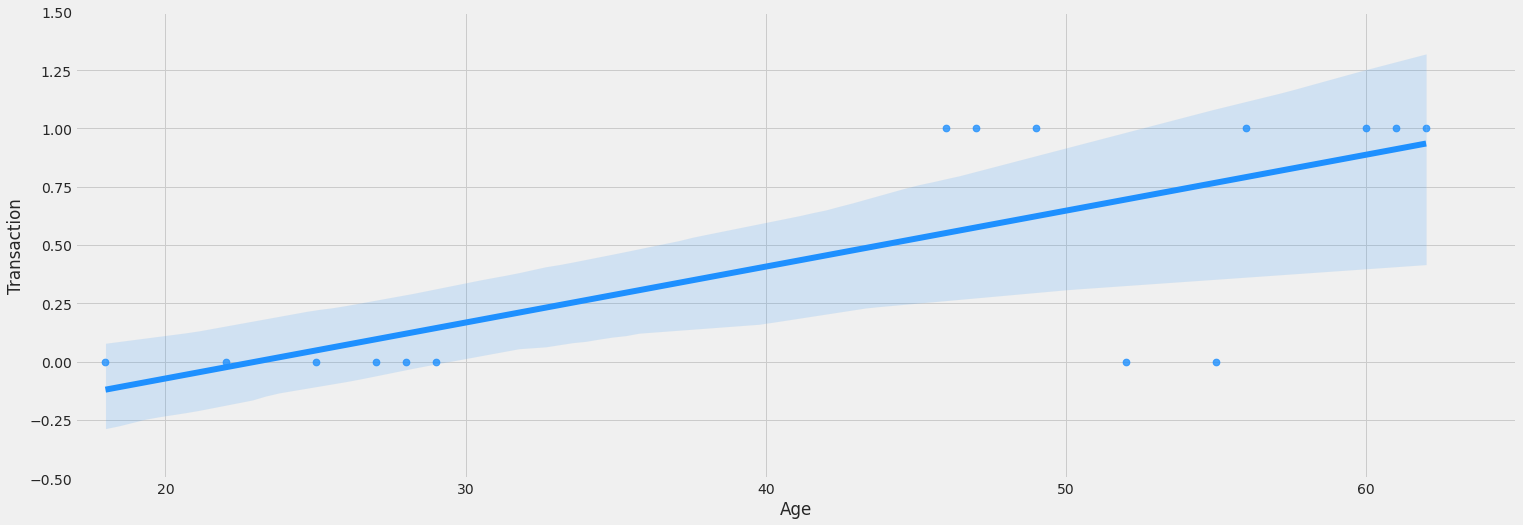

In [ ]:
ax = sns.regplot(x = 'Age', y = 'Transaction', data = funeral_df, scatter_kws={'s':45}, color = 'dodgerblue', ci = 99)
plt.xlim([17,65])
plt.ylim([-.5,1.5]);
#Hint: A lack of confidence is illustrated in the wider confidence bands at the higher age groups

##Takeaways?

#Let's give the data set another go using sklearn's implementation of logistic regression.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(funeral_df[['Age']], funeral_df[['Transaction']], test_size = .35)

In [ ]:
#Initialize Logistic Regressor 
model = LogisticRegression()

In [ ]:
#Fit the model
model.fit(X_train, y_train.values.ravel());

In [ ]:
#Let's score the model
model.score(X_test, y_test)

0.8333333333333334

In [ ]:
X_test

,Age
0,22
12,27
7,60
9,61
6,55
1,25


In [ ]:
#Get predictions for the test set.
#Each value corresponds to a transaction outcome of 0 (no) or 1 (yes)
model.predict(X_test)

array([0, 0, 1, 1, 1, 0])

In [ ]:
#Now, let's take a look at the probabilities of each record.
#The structure below has two data points per record.
#The first data point contains the probability of this record NOT transacting
#The second data point contains the probability of this record POSITIVELY transacting
model.predict_proba(X_test)

array([[0.97559249, 0.02440751],
       [0.94212194, 0.05787806],
       [0.04151238, 0.95848762],
       [0.03492387, 0.96507613],
       [0.096128  , 0.903872  ],
       [0.9588748 , 0.0411252 ]])

In [ ]:
#To understand how the model performs, let's take a look at the actuals, predictions, and probabilities together!
prediction_df = pd.DataFrame(model.predict(X_test), columns = {'Prediction'}).set_index([pd.Index(X_test.index)])
probability_df = pd.DataFrame(model.predict_proba(X_test)).set_index([pd.Index(X_test.index)])
all_together_df = X_test.join(y_test).join(prediction_df).join(probability_df)
all_together_df

,Age,Transaction,Prediction,0,1
0,22,0,0,0.975592,0.024408
12,27,0,0,0.942122,0.057878
7,60,1,1,0.041512,0.958488
9,61,1,1,0.034924,0.965076
6,55,0,1,0.096128,0.903872
1,25,0,0,0.958875,0.041125


In [ ]:
#Now, let's use the model to predict funeral plot purchases for arbitrary values
arbitrary_values = pd.DataFrame(data = {'Age': [0,25,50,75,100]})
arbitrary_values.join(pd.DataFrame(model.predict(arbitrary_values), columns = {'Prediction'}).set_index([pd.Index(arbitrary_values.index)]))

,Age,Prediction
0,0,0
1,25,0
2,50,1
3,75,1
4,100,1


##How would the above influence your future marketing campaigns to sell funeral plots?

In [ ]:
#As a fun experiment, let's create a data structure that contains the probabilities for a broad age range.
exhaustive_data = {'Age':range(101)} 
exhaustive_data_df = pd.DataFrame(exhaustive_data)
prediction_df2 = pd.DataFrame(model.predict(exhaustive_data_df), columns = {'Prediction'}).set_index([pd.Index(exhaustive_data_df.index)])
probability_df2 = pd.DataFrame(model.predict_proba(exhaustive_data_df)).set_index([pd.Index(exhaustive_data_df.index)])
all_together_df2 = exhaustive_data_df.join(prediction_df2).join(probability_df2)
all_together_df2.head(3)

,Age,Prediction,0,1
0,0,0,0.999520,0.000480
1,1,0,0.999425,0.000575
2,2,0,0.999312,0.000688


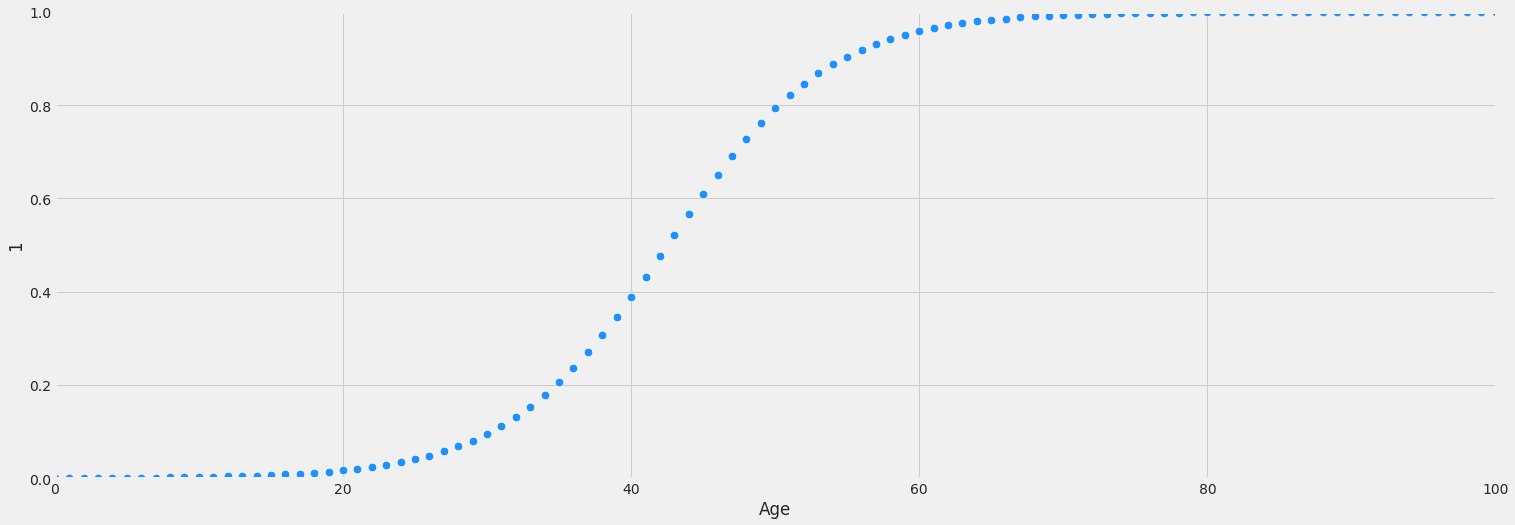

In [ ]:
#Now let's plot the results!
ax = sns.scatterplot(x = 'Age', y = 1, data = all_together_df2, s = 75, color = 'dodgerblue')
plt.xlim([0,100])
plt.ylim([0,1]);

/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/links.py:190: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:889: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)


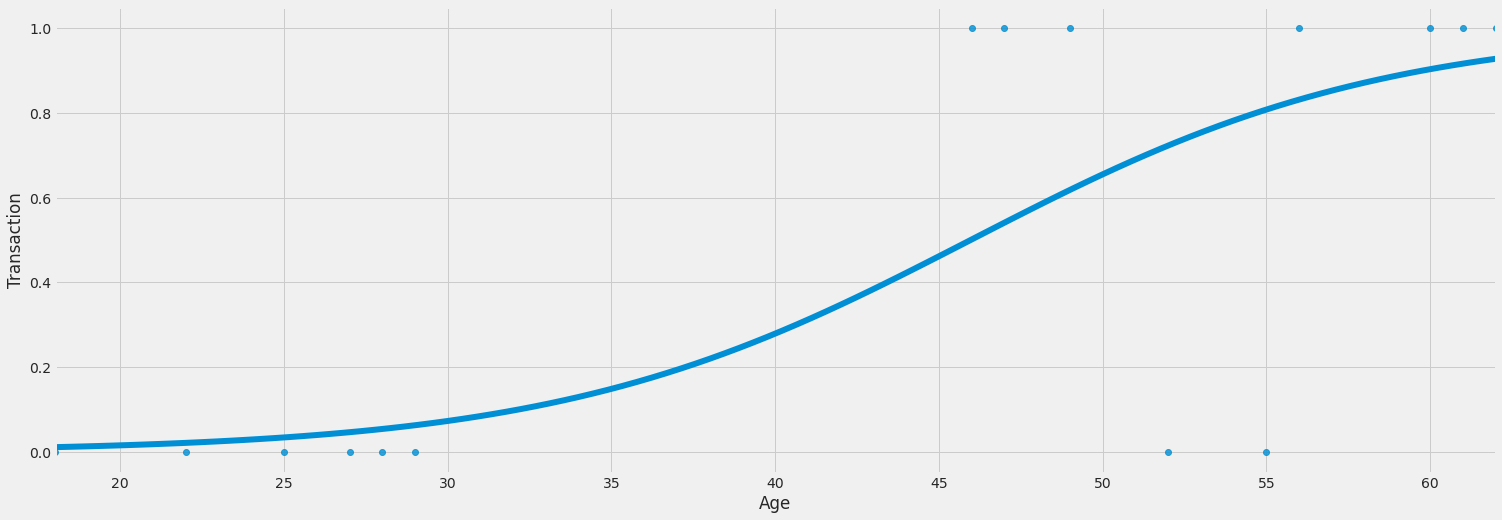

In [ ]:
#Too easy
sns.regplot(x='Age', y='Transaction', data=funeral_df, logistic=True);

#Convinced?

In [ ]:
#Can you use logistic regression to predict when people are going to leave a company?
#Analyze the variables below
#Determine why people leave companies
#Graph clear relationships between key variables and attrition
#Build a logistic regression model to make predictions
#Assess the performance of your model
#Explore 2 alternative approaches to your model and assess their performance

attrition_df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSG-GQwdpZkTC-UV9cTMCjhSwkmc5VNb-IzH5yG6neHxk3dB_a-Ttlg-8Nynttq_NmnROAt-OZmx9Ax/pub?gid=925359326&single=true&output=csv')
attrition_df.head(3)

,emp_sat,last_perf,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5,dept,sal
0,0.38,0.53,2,157,3,0,1,0,SALES,SMALL
1,0.8,0.86,5,262,6,0,1,0,SALES,MEDIUM
2,0.11,0.88,7,272,4,0,1,0,SALES,MEDIUM


#Regularized Models
##Borrowed From: https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/

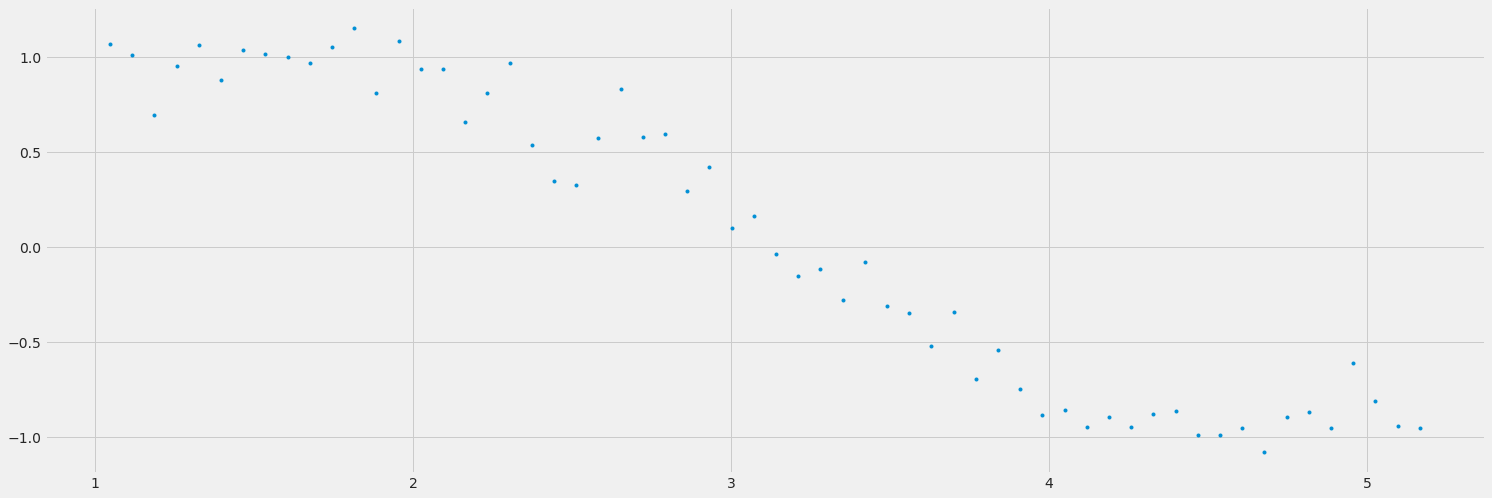

In [ ]:
#Define input array with angles from 60deg to 300deg converted to radians
x = np.array([i*np.pi/180 for i in range(60,300,4)])
np.random.seed(10)  #Setting seed for reproducability
y = np.sin(x) + np.random.normal(0,0.15,len(x))
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'.')

##To test the ability to predict, add columns for X^2 through X^15

In [ ]:
for i in range(2,16):  #power of 1 is already there
    colname = 'x_%d'%i      #new var will be x_power
    data[colname] = data['x']**i
data.head(3)

,x,y,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15
0,1.047198,1.065763,1.096623,1.148381,1.202581,1.259340,1.318778,1.381021,1.446202,1.514459,1.585938,1.660790,1.739176,1.821260,1.907219,1.997235
1,1.117011,1.006086,1.247713,1.393709,1.556788,1.738948,1.942424,2.169709,2.423588,2.707173,3.023942,3.377775,3.773011,4.214494,4.707635,5.258479
2,1.186824,0.695374,1.408551,1.671702,1.984016,2.354677,2.794587,3.316683,3.936319,4.671717,5.544505,6.580351,7.809718,9.268760,11.000386,13.055521


In [ ]:
#Import Linear Regression model from scikit-learn.
def linear_regression(data, power, models_to_plot):
    #initialize predictors:
    predictors=['x']
    if power>=2:
        predictors.extend(['x_%d'%i for i in range(2,power+1)])
    
    #Fit the model
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors],data['y'])
    y_pred = linreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered power
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for power: %d'%power)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

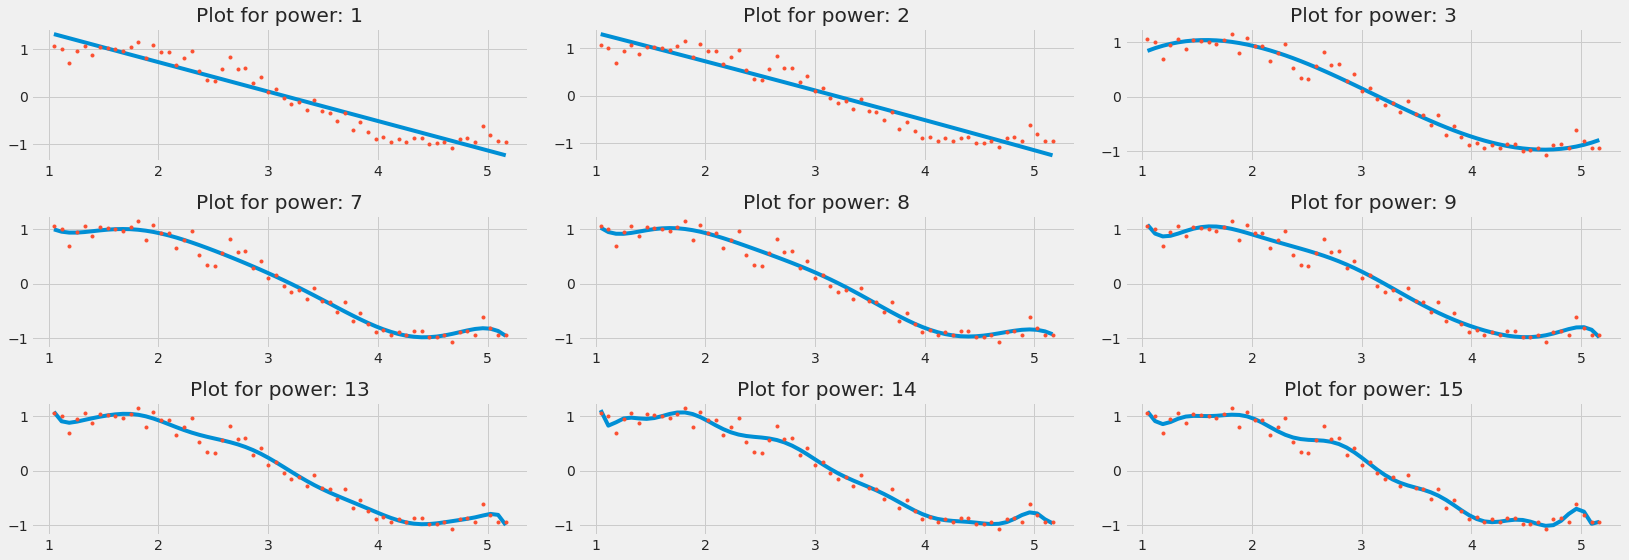

In [ ]:
#Initialize a dataframe to store the results:
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['model_pow_%d'%i for i in range(1,16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

#Define the powers for which a plot is required:
#models_to_plot = {1:231,3:232,6:233,9:234,12:235,15:236}
models_to_plot = {1:331, 2:332, 3:333, 7:334, 8:335, 9:336, 13:337, 14:338, 15:339}

#Iterate through all powers and assimilate results
for i in range(1,16):
    coef_matrix_simple.iloc[i-1,0:i+2] = linear_regression(data, power=i, models_to_plot=models_to_plot)
    

In [ ]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
model_pow_1,3.3,2,-0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,3.3,1.9,-0.58,-0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,1.1,-1.1,3,-1.3,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,1.1,-0.27,1.7,-0.53,-0.036,0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,1,3,-5.1,4.7,-1.9,0.33,-0.021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,0.99,-2.8,9.5,-9.7,5.2,-1.6,0.23,-0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,0.93,19,-56,69,-45,17,-3.5,0.4,-0.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,0.92,43,-1.4e+02,1.8e+02,-1.3e+02,58,-15,2.4,-0.21,0.0077,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,0.87,1.7e+02,-6.1e+02,9.6e+02,-8.5e+02,4.6e+02,-1.6e+02,37,-5.2,0.42,-0.015,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_10,0.87,1.4e+02,-4.9e+02,7.3e+02,-6e+02,2.9e+02,-87,15,-0.81,-0.14,0.026,-0.0013,NaN,NaN,NaN,NaN,NaN


In [ ]:
def ridge_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    
    ridgereg.fit(data[predictors],data['y'])
    y_pred = ridgereg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    aic = len(data)*np.log(rss/len(data)) + 2*(len(data.columns)-1)
    ret = [rss]
    ret.extend([aic])
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=3.81609e-17): result may not be accurate.
  overwrite_a=True).T


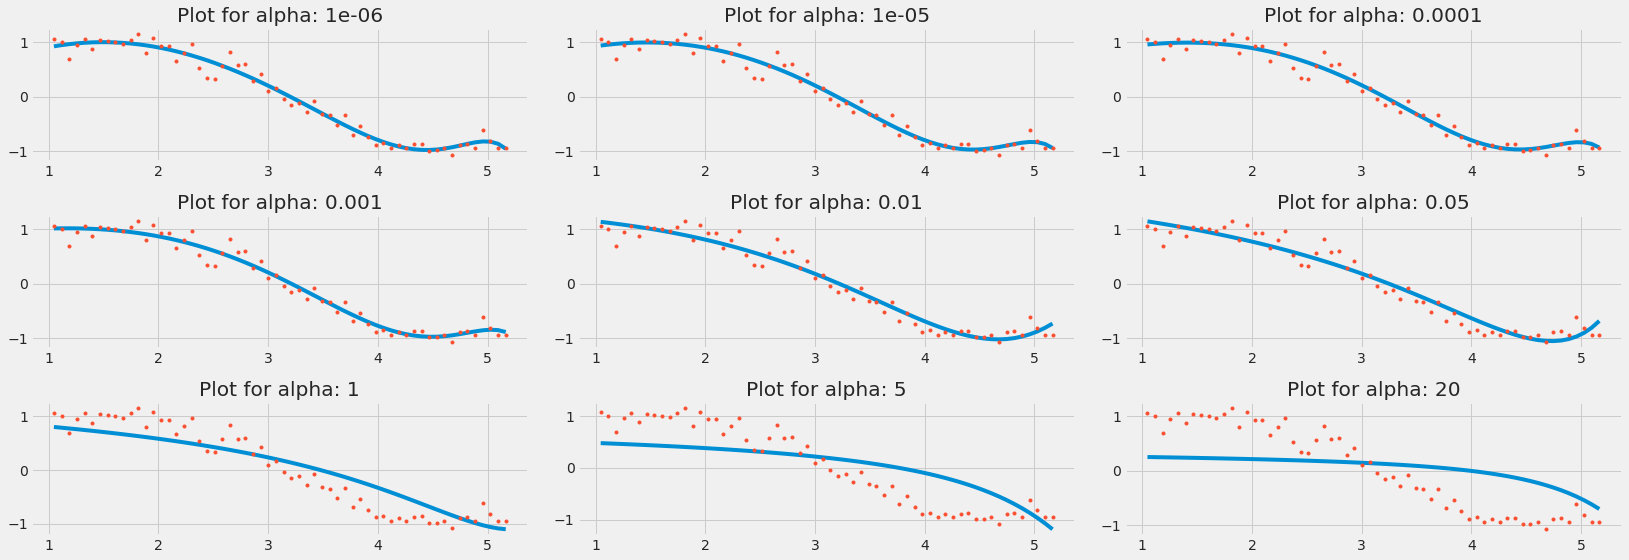

In [ ]:
#Initialize predictors to be set of 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Set the different values of alpha to be tested
alpha_ridge = [1e-15, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, .5e-1, 1, 5, 20]

#Initialize the dataframe for storing coefficients.
col = ['sse','aic','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-6:331, 1e-5:332, 1e-4:333, 1e-3:334, 1e-2:335, .5e-1:336, 1:337, 5:338, 20:339}
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, alpha_ridge[i], models_to_plot)

##Key takeaway: As Alpha INCREASES, model complexity DECREASES

In [ ]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.4g}'.format
coef_matrix_ridge

,sse,aic,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,0.8731,-223.8,94.31,-298.3,378.3,-236.5,67.76,-1.173,-3.693,0.305,0.1891,-0.0215,-0.007678,0.00106,0.0002464,-6.346e-05,4.609e-06,-9.006e-08
alpha_1e-06,0.9532,-218.5,0.1958,1.015,-0.2588,-0.04632,0.002244,0.001406,0.0001521,-1.473e-05,-8.285e-06,-1.443e-06,-3.72e-08,5.795e-08,2.109e-08,4.082e-09,1.468e-10,-2.717e-10
alpha_1e-05,0.957,-218.3,0.3558,0.8196,-0.2221,-0.02693,-0.0003101,0.0003346,5.047e-05,2.421e-06,-3.996e-08,1.723e-07,1.048e-07,3.389e-08,7.45e-09,9.509e-10,-9.597e-11,-1.177e-10
alpha_0.0001,0.962,-218,0.5613,0.5465,-0.1281,-0.02571,-0.00282,-0.0001103,4.057e-05,1.521e-05,3.652e-06,7.366e-07,1.304e-07,1.944e-08,1.935e-09,-1.303e-10,-1.549e-10,-6.177e-11
alpha_0.001,1.002,-215.6,0.8176,0.3051,-0.08669,-0.02048,-0.002836,-0.0002192,1.812e-05,1.24e-05,3.43e-06,7.282e-07,1.293e-07,1.869e-08,1.706e-09,-1.511e-10,-1.404e-10,-5.16e-11
alpha_0.01,1.436,-194,1.299,-0.0884,-0.0515,-0.0101,-0.001412,-0.0001315,7.231e-07,4.136e-06,1.305e-06,2.964e-07,5.616e-08,8.972e-09,1.094e-09,4.292e-11,-3.142e-11,-1.487e-11
alpha_0.05,1.793,-180.6,1.424,-0.2188,-0.03739,-0.00597,-0.0008292,-9.438e-05,-6.716e-06,5.164e-07,3.59e-07,1.021e-07,2.295e-08,4.532e-09,8.078e-10,1.288e-10,1.737e-11,1.544e-12
alpha_1,5.649,-111.8,0.9689,-0.139,-0.01927,-0.003004,-0.0004655,-6.97e-05,-9.901e-06,-1.292e-06,-1.428e-07,-9.33e-09,1.307e-09,7.803e-10,2.402e-10,6.156e-11,1.446e-11,3.227e-12
alpha_5,13.84,-58.01,0.5483,-0.05887,-0.008522,-0.001419,-0.000241,-4.083e-05,-6.874e-06,-1.149e-06,-1.905e-07,-3.131e-08,-5.092e-09,-8.17e-10,-1.288e-10,-1.983e-11,-2.95e-12,-4.162e-13
alpha_20,22.72,-28.26,0.2767,-0.02247,-0.003405,-0.0005993,-0.0001085,-1.974e-05,-3.601e-06,-6.576e-07,-1.203e-07,-2.204e-08,-4.048e-09,-7.451e-10,-1.374e-10,-2.541e-11,-4.709e-12,-8.744e-13


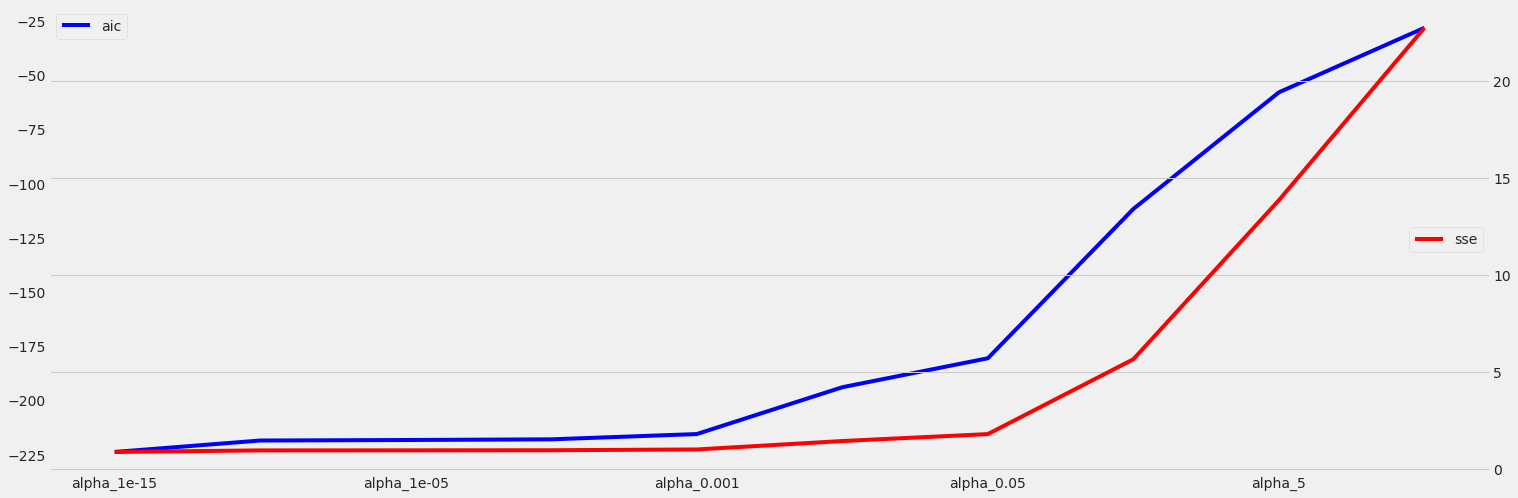

In [ ]:
ax1 = coef_matrix_ridge.aic.plot( color = 'blue')
plt.legend(loc = 'center left')
#plt.gca().invert_yaxis()
ax2 = coef_matrix_ridge.sse.plot(color='red', secondary_y = True)
plt.legend(loc = 'center right')
plt.show()

In [ ]:
coef_matrix_ridge.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15     0
alpha_1e-06     0
alpha_1e-05     0
alpha_0.0001    0
alpha_0.001     0
alpha_0.01      0
alpha_0.05      0
alpha_1         0
alpha_5         0
alpha_20        0
dtype: int64

##Key Takeaway: All Coefficients are non-zero values

In [ ]:
def lasso_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    lassoreg = Lasso(alpha=alpha, normalize=True, max_iter=1e6)
    lassoreg.fit(data[predictors],data['y'])
    y_pred = lassoreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    aic = len(data)*np.log(rss/len(data)) + 2*(len(data.columns)-1)
    ret = [rss]
    ret.extend([aic])
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

In [ ]:
data.head(1)

,x,y,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15
0,1.047,1.066,1.097,1.148,1.203,1.259,1.319,1.381,1.446,1.514,1.586,1.661,1.739,1.821,1.907,1.997


In [ ]:
predictors

['x',
 'x_2',
 'x_3',
 'x_4',
 'x_5',
 'x_6',
 'x_7',
 'x_8',
 'x_9',
 'x_10',
 'x_11',
 'x_12',
 'x_13',
 'x_14',
 'x_15']

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.47700851674434125, tolerance: 0.00369480384218441
  positive)


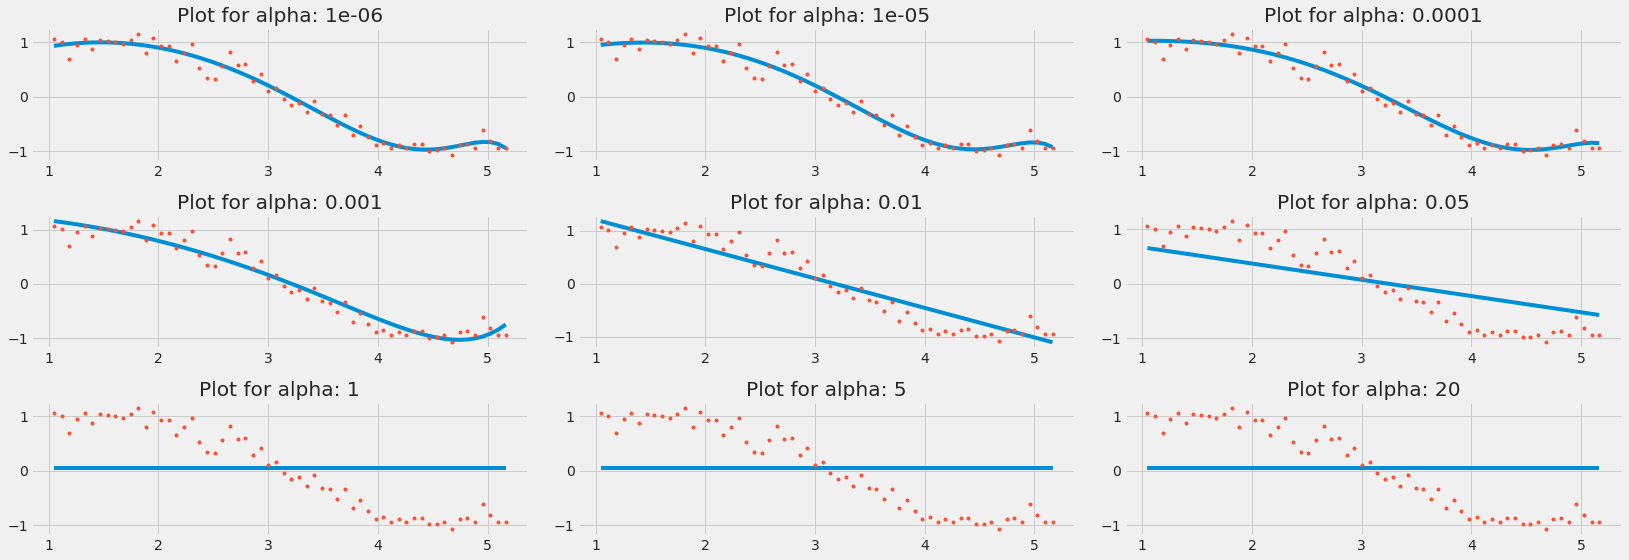

In [ ]:
#Initialize predictors to all 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Define the alpha values to test
alpha_lasso = [1e-15, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, .5e-1, 1, 5, 20]

#Initialize the dataframe to store coefficients
col = ['sse','aic','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

#Define the models to plot
models_to_plot = {1e-6:331, 1e-5:332, 1e-4:333, 1e-3:334, 1e-2:335, .5e-1:336, 1:337, 5:338, 20:339}

#Iterate over the 10 alpha values:
for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_regression(data, predictors, alpha_lasso[i], models_to_plot)

In [ ]:
pd.options.display.float_format = '{:,.4g}'.format
coef_matrix_lasso

,sse,aic,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,0.954,-218.5,-0.03317,1.404,-0.4587,-0.02718,0.01008,0.001135,-0.0001149,-5.179e-05,-7.537e-06,-9.846e-08,2.604e-07,8.567e-08,1.718e-08,1.979e-09,-1.765e-10,-1.99e-10
alpha_1e-06,0.9565,-218.3,0.2341,1.038,-0.3524,-0,0,1.285e-05,0,0,0,0,2.896e-07,4.621e-08,3.738e-09,0,0,-1.142e-10
alpha_1e-05,0.9613,-218,0.5042,0.6043,-0.1281,-0.03822,-0,0,0,0,7.727e-06,1.003e-06,7.725e-08,0,0,0,-0,-6.95e-11
alpha_0.0001,1.033,-213.7,0.903,0.1711,-0,-0.04778,-0,-0,0,0,9.465e-06,5.1e-07,0,0,0,-0,-0,-4.404e-11
alpha_0.001,1.679,-184.6,1.295,-0,-0.1261,-0,-0,-0,0,0,0,0,0,1.496e-08,7.526e-10,0,0,0
alpha_0.01,3.639,-138.2,1.759,-0.5521,-0.0005623,-0,-0,-0,-0,-0,-0,-0,0,0,0,0,0,0
alpha_0.05,12.28,-65.18,0.9677,-0.2992,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_1,36.95,0.9101,0.03803,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_5,36.95,0.9101,0.03803,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_20,36.95,0.9101,0.03803,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0


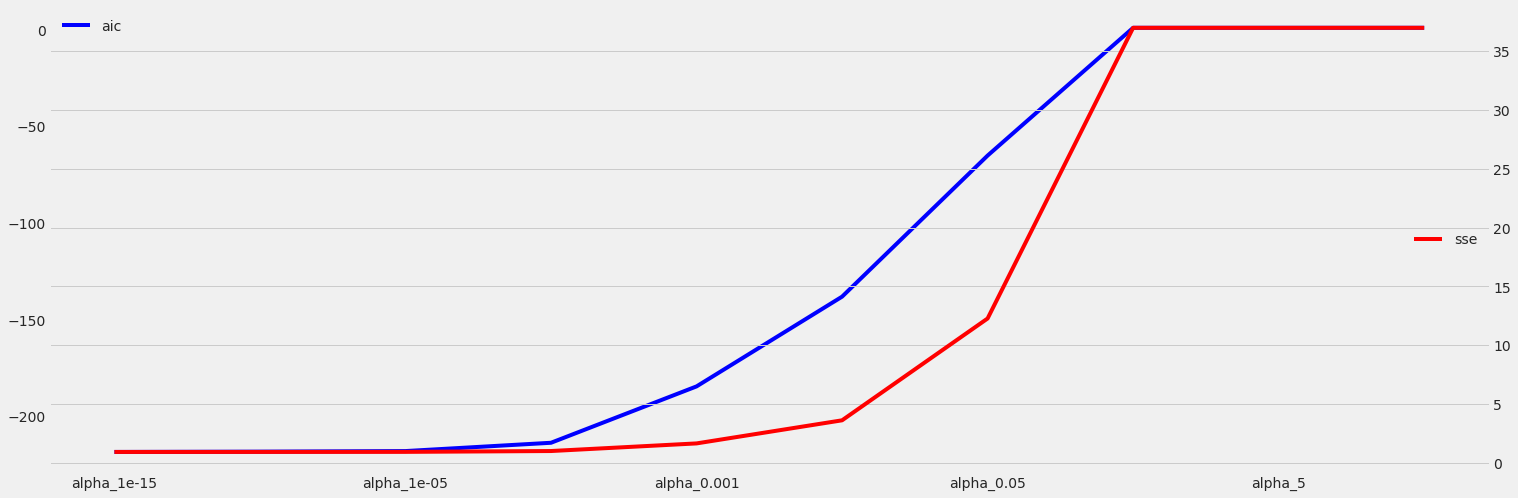

In [ ]:
ax1 = coef_matrix_lasso.aic.plot( color = 'blue')
plt.legend(loc = 'center left')
#plt.gca().invert_yaxis()
ax2 = coef_matrix_lasso.sse.plot(color='red', secondary_y = True)
plt.legend(loc = 'center right')
plt.show()

In [ ]:
coef_matrix_lasso.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15      0
alpha_1e-06      8
alpha_1e-05      8
alpha_0.0001    10
alpha_0.001     12
alpha_0.01      13
alpha_0.05      14
alpha_1         15
alpha_5         15
alpha_20        15
dtype: int64

##Key takeaway: Some coefficients are zeros!